# 5. Predictions using an ensemble model

### Ensemble Model
- All of our models have subpar accuracy so far
- What would the accuracy be in our predictions if we created a stacked ensemble model?

In [14]:
#Dependencies
import time
from datetime import datetime
import pandas as pd
import pandas_gbq
import numpy as np
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt

#Keras
import tensorflow as tf
import keras
from keras import initializers
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from livelossplot.keras import PlotLossesCallback

#Sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

#Saving packages
import pickle
import joblib

In [21]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13498707019011905724
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1426669833260511167
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3095706815166863027
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1369873376964818652
physical_device_desc: "device: XLA_GPU device"
]


In [23]:
#Confirm keras is using GPU
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

#Manually set GPU config
config = tf.ConfigProto(device_count = {'GPU': 1, 'CPU': 8})
sess = tf.Session(config=config)
keras.backend.set_session(sess)

['/job:localhost/replica:0/task:0/device:GPU:0']


In [24]:
#Normalize data

def normalize(X_train):
    mean_val = np.mean(X_train, axis=0)
    train_max = np.max(X_train, axis=0)
    train_min = np.min(X_train,axis=0)
    
    train_norm = np.asanyarray((X_train-mean_val)/(train_max - train_min))
    
    return train_norm    

In [25]:
#Call BigQuery

"""
1st - Call bigquery and create new dataset then tables
2nd - Upload jsons to bigquery
3rd - Query the data tables to pull in the necessary information
"""

#1 Call bigquery and create new dataset then tables

#Call BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account

#credentials 
credentials = service_account.Credentials.from_service_account_file(
    '*****_credentials.json')

#Project id name
project_id = '*****'

#create the client
client = bigquery.Client(credentials= credentials,project=project_id)

In [27]:
#Import data
sql = """
    SELECT A.sku, A.inventory, A.pieces_past_due, A.min_rec_stock,
      B.sales_1_mon, B.sales_3_mon, B.sales_6_mon,
      C.forecast_3_mon, C.forecast_6_mon,
      D.lead_time, D.potential_issue,
      E.backorder
FROM `backorder_chain_example.inventory` as A
INNER JOIN  `backorder_chain_example.sales`  as B
ON A.sku = B.sku
INNER JOIN `backorder_chain_example.forecast` as C
ON A.sku = C.sku
INNER JOIN `backorder_chain_example.inventory_ordering` as D
ON A.sku = D.sku
INNER JOIN `backorder_chain_example.backorder` as E
ON A.sku = E.sku
  """
start = time.time()

#We will re-create the dataframe we created earlier from our SQL query
df = pd.read_gbq(sql, dialect='standard', project_id=project_id)

end = time.time()
print("Query time was " + str(np.round((end-start)/60,2)) + " minutes")

Query time was 2.47 minutes


In [28]:
#Define X and y
y = df['backorder']
X = df.drop(columns=['backorder'])
y_classes = np.array(['no_backorder', 'Backorder'])

#Get training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

#Get test and dev sets
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size = 0.03, random_state = 1)

X_train = X_train.drop(columns=['sku'])
test_sku = X_test['sku']
X_test = X_test.drop(columns=['sku'])
dev_sku = X_dev['sku']
X_dev = X_dev.drop(columns=['sku'])

#Shape
print("Training shape: " + str(X_train.shape))
print("Dev shape: " + str(X_dev.shape))
print("Test shape: " + str(X_test.shape))

Training shape: (750000, 10)
Dev shape: (727500, 10)
Test shape: (22500, 10)


In [29]:
#Using smote to rebalance data
from collections import Counter

#Import oversampling 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

#Resample
train_count = Counter(y_train)
dev_count = Counter(y_dev)
print(f"Unbalanced count for training data is {train_count}")
print(f"Unbalanced count for dev data is {dev_count}")

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

X_dev_res, y_dev_res = sm.fit_resample(X_dev, y_dev)

training_resampled_count = Counter(y_train_res)
dev_resampled_count = Counter(y_dev_res)
print(f"Rebalanced count for training data is {training_resampled_count}")
print(f"Rebalanced count for dev data is {dev_resampled_count}")

Unbalanced count for training data is Counter({0: 712415, 1: 37585})
Unbalanced count for dev data is Counter({0: 691221, 1: 36279})
Rebalanced count for training data is Counter({0: 712415, 1: 712415})
Rebalanced count for dev data is Counter({0: 691221, 1: 691221})


In [31]:
#Backorder class

class BackorderPredict(): 
    
    """
    Ensemble model for predicting backorder
    """

    def __init__(self, n_iter=3, cv=3, n_jobs=-1):
        """
        Called when initializing the classifier
        """
        self.n_iter = n_iter
        self.cv = cv
        self.n_jobs = n_jobs
        
    def fit(self, X_train, y_train, X_dev, y_dev):
        
        """
        ///////////////////////////////////Layer 1 of ensemble model ////////////////////////////////////////
        """
    
        #--------------------------Create logistic regression pipe--------------------------------------------
        lr_pipe = Pipeline([('scale', StandardScaler()),
                         ("logistic_regression", LogisticRegression(random_state=0, solver='lbfgs'))])

        #Fit lr model
        lr_pipe.fit(X_train, y_train)
    
        # save the model
        lr_filename = 'Data/lr_pipe.sav'
        joblib.dump(lr_pipe, lr_filename)
        print("Logistic regression complete and saved")

        #----------------------------Create random forest pipe-------------------------------------------------
        rf_clf = RandomForestClassifier(n_estimators=20, n_jobs=self.n_jobs, random_state=0)

        #Specify parameters and distributions to sample from
        param_dist = {"max_depth": [3, None],
                      "max_features": sp_randint(1, 10),
                      "min_samples_split": sp_randint(2, 10),
                      "bootstrap": [True, False],
                      "criterion": ["gini", "entropy"]}
    
        #RF model
        rf_model = RandomizedSearchCV(rf_clf, param_distributions=param_dist,
                                   n_iter=self.n_iter, cv=self.cv, iid=False)
    
        #RF pipe
        rf_pipe = Pipeline([('scale', StandardScaler()),
                            ("Random forest", rf_model)])

        #Fit rf model
        rf_pipe.fit(X_train, y_train)
    
        # save the model to disk
        rf_filename = 'Data/rf_pipe.sav'
        joblib.dump(rf_pipe, rf_filename)
        print("Random forest complete and saved")
        
        #----------------------------Create neural network-------------------------------------------------------------------------------
    
        X_train_norm = normalize(X_train)

        input_dim_ = X_train_norm.shape[1]
    
        #Build and compile model (3 layers)
        nn_model = Sequential()
        nn_model.add(Dense(10, input_dim = input_dim_, activation='relu', bias_initializer=initializers.Constant(value=0.1)))
        nn_model.add(Dense(5, activation='relu', bias_initializer=initializers.Constant(value=0.1)))
        nn_model.add(Dense(1, activation='sigmoid'))
        nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
        #Fit
        start = time.time()
        
        nn_model.fit(X_train_norm, y_train, 
                     verbose=0, validation_split= .01, 
                     epochs=100, batch_size=128, 
                     callbacks=[PlotLossesCallback()])
        
        end = time.time()
        print("NN training time was " + str(np.round((end-start)/60,2)) + " minutes")
        
        # save the model to disk
        nn_model.save("Data/nn_model.h5")
        print("Neural net complete and saved")
        
         #-------------Get pedictions and probabilities------------------------------------------------------------------------------------
    
        models = {"lr":lr_pipe, "rf":rf_pipe, "nn":nn_model}
        probs={}
        preds={}
        for name,model in models.items():
            if name != "nn":
                probs[name] = model.predict_proba(X_dev)[:,1:].ravel()
                preds[name] = model.predict(X_dev)
            else:
                X_dev_norm = normalize(X_dev)
                probs[name] = model.predict(X_dev_norm).ravel()
                preds[name] = model.predict_classes(X_dev_norm).ravel() 
            
        #Calcualte correct predictions of backorders
        accuracy_weights={}
        for name in preds.keys():
            sub_preds = preds[name]
            matrix = confusion_matrix(y_dev, sub_preds)
            array = matrix / matrix.astype(np.float).sum(axis=1)[:, np.newaxis]
            accuracy_weights[name] = np.round(array[1][1].astype(float), 4)
        
        #Save accuracy weights
        with open('Data/accuracy_weights.pickle', 'wb') as handle:
            pickle.dump(accuracy_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
        #Create weighted dictionary
        weighted_probs = {name: np.multiply(probs[name], accuracy_weights[name]) for name in accuracy_weights.keys()}
       
        #Convert dictionary into dataframe
        weighted_df = pd.DataFrame.from_dict(weighted_probs)
        
        """
        ///////////////////////////////////Layer 2 of ensemble model ////////////////////////////////////////
        """
    
        #Normalize predictions
        weighted_df_norm = normalize(weighted_df)

        input_dim_ = weighted_df_norm.shape[1]
    
        #Build and compile network
        nn_model_stack = Sequential()
        nn_model_stack.add(Dense(3, input_dim = input_dim_, activation='relu', bias_initializer=initializers.Constant(value=0.1)))               
        nn_model_stack.add(Dense(5, activation='relu',bias_initializer=initializers.Constant(value=0.1)))
        nn_model_stack.add(Dense(1, activation='sigmoid'))
        nn_model_stack.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        #Run the model
        nn_model_stack.fit(weighted_df_norm, y_dev, 
                           verbose=0, validation_split= .01, 
                           epochs=100, batch_size=128, 
                           callbacks=[PlotLossesCallback()])

        # save the model to disk
        nn_model_stack.save("Data/nn_model_stack.h5")
        print('Meta-learner now finished and saved')
        
    def predict_prob(self, X_test):
        
        #------------------------Load models-------------------------------------
    
        #load the logistic regression model
        lr_pipe = joblib.load('Data/lr_pipe.sav')
    
        #load random forest model
        rf_pipe = joblib.load('Data/rf_pipe.sav')
    
        #load neural network #1
        nn_model = load_model('Data/nn_model.h5')
    
        #load neural network #2
        nn_model_stack = load_model('Data/nn_model_stack.h5')
    
        #Import accuracy weights
        with open("Data/accuracy_weights.pickle", "rb") as input_file:
            accuracy_weights = pickle.load(input_file)
            
        for name in accuracy_weights.keys():
            if not accuracy_weights[name] > 0.0:
                raise ValueError(f"{name} is not greater than zero")
    
        #------------------------Get predictions-----------------------------------

        models = {"lr":lr_pipe, "rf":rf_pipe, "nn":nn_model}
        probs={}
        preds={}
        for name,model in models.items():
            if name != "nn":
                probs[name] = model.predict_proba(X_test)[:,1:].ravel()
                preds[name] = model.predict(X_test)
            else:
                X_test_norm = normalize(X_test)
                probs[name] = model.predict(X_test_norm).ravel()
                preds[name] = model.predict_classes(X_test_norm).ravel() 
            
        #Create weighted dictionary
        weighted_probs = {}
        for name in accuracy_weights.keys():
            weighted_probs[name] = np.multiply(probs[name], accuracy_weights[name])
    
        #Convert dictionary into dataframe
        weighted_df = pd.DataFrame.from_dict(weighted_probs)
    
    
        #-----------------------Get predictions from 2nd layer-------------------------
    
        #Normalize predictions
        weighted_df_norm = normalize(weighted_df)
    
        new_predictions = nn_model_stack.predict(weighted_df_norm).ravel()
    
        return new_predictions  
    
    def predict_class(self, X_test):
        
        #------------------------Load models-------------------------------------
    
        #load the logistic regression model
        lr_pipe = joblib.load('Data/lr_pipe.sav')
    
        #load random forest model
        rf_pipe = joblib.load('Data/rf_pipe.sav')
    
        #load neural network #1
        nn_model = load_model('Data/nn_model.h5')
    
        #load neural network #2
        nn_model_stack = load_model('Data/nn_model_stack.h5')
    
        #Import accuracy weights
        with open("Data/accuracy_weights.pickle", "rb") as input_file:
            accuracy_weights = pickle.load(input_file)
            
        for name in accuracy_weights.keys():
            if not accuracy_weights[name] > 0.0:
                raise ValueError(f"{name} is not greater than zero")
    
        #------------------------Get predictions-----------------------------------

        models = {"lr":lr_pipe, "rf":rf_pipe, "nn":nn_model}
        probs={}
        preds={}
        for name,model in models.items():
            if name != "nn":
                probs[name] = model.predict_proba(X_test)[:,1:].ravel()
                preds[name] = model.predict(X_test)
            else:
                X_test_norm = normalize(X_test)
                probs[name] = model.predict(X_test_norm).ravel()
                preds[name] = model.predict_classes(X_test_norm).ravel() 
            
        #Create weighted dictionary
        weighted_probs = {}
        for name in accuracy_weights.keys():
            weighted_probs[name] = np.multiply(probs[name], accuracy_weights[name])
    
        #Convert dictionary into dataframe
        weighted_df = pd.DataFrame.from_dict(weighted_probs)
    
    
        #-----------------------Get predictions from 2nd layer-------------------------
    
        #Normalize predictions
        weighted_df_norm = normalize(weighted_df)
    
        new_predictions = nn_model_stack.predict(weighted_df_norm).ravel()
        
        predictions = np.where(new_predictions >= 0.5, 1, 0)
    
        return predictions

In [33]:
model = BackorderPredict()

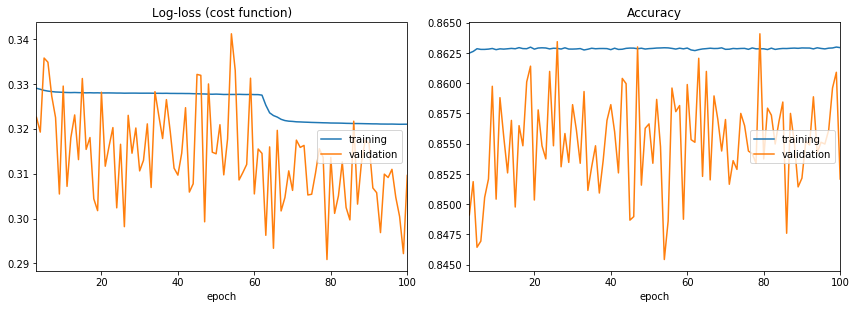

Log-loss (cost function):
training   (min:    0.321, max:    0.337, cur:    0.321)
validation (min:    0.291, max:    0.341, cur:    0.310)

Accuracy:
training   (min:    0.862, max:    0.863, cur:    0.863)
validation (min:    0.845, max:    0.864, cur:    0.852)
Meta-learner now finished and saved


In [30]:
model.fit(X_train_res,y_train_res, X_dev_res,y_dev_res)

In [35]:
y_preds = model.predict_class(X_test)

In [34]:
np.save('y_preds', y_preds)

In [40]:
#Define confusion plot
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [41]:
print(len(y_preds))
print(len(y_test))

22500
22500


Normalized confusion matrix
[[0.56351807 0.43648193]
 [0.10827465 0.89172535]]


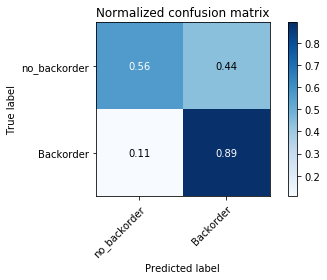

In [42]:
plot_confusion_matrix(y_test,y_preds, classes=y_classes, normalize=True)

### We have increased accuracy in our backorder prediction but reduced accuracy in predicitng all others
- This is to be expected due to the extreme noise and overlap in the data